# Correlations between transcriptome and microbiome

I (RACS) am using this notebook using the ASVs (q20, fw, without any filtering step nor rarefying...) and the RNAseq just to test getting significance for Pearson correlations.

# Associations between RNAseq and 16S



Using `0_kremling_expression_key.txt` from [Dr. Wallace`s FigShare](https://doi.org/10.6084/m9.figshare.5886769.v2) to map SRAs from both data (16S and metataxonomics).

In [1]:
kremling_expression_key = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
sra_run_table_16s = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
sra_run_table_rnaseq = '/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'
#kremling_expression_key = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/correlations_rnaseq_metataxonomics/0_kremling_expression_key.txt'
#sra_run_table_16s = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/SraRunInfo_Wallace_etal_2018.csv'
#sra_run_table_rnaseq = '/home/rsantos/Repositories/maize_microbiome_transcriptomics/rnaseq_kremling2018/run_info/SraRunInfo_Kremling_etal_2018.csv'

dict_wallace_kremling_2018 = {}
kremling_expression_key_dict = {}

In [2]:
with open(kremling_expression_key, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split('\t')
        
        kremling_identifier = fields[0]
        wallace_identifier = fields[1]

        kremling_expression_key_dict[kremling_identifier] = wallace_identifier
        kremling_expression_key_dict[wallace_identifier] = kremling_identifier

In [3]:
import re

with open(sra_run_table_rnaseq, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('_')
        rnaseq_run_id = fields[0]
        sample_id = fields2[1]
        rnaseq_genotype = fields2[2]
        day = ''
        match = re.search(r'\d+', sample_id)
        unmatched_parts = re.split(r'\d+', sample_id)
        day_period = unmatched_parts[0]
        if match:
            day = int(match.group())
        if sample_id.startswith('LMA') and rnaseq_genotype != '#N/A':
            dict_wallace_kremling_2018[fields[11]] = {'run_accession_16s': '',
                                    'run_accession_rnaseq': rnaseq_run_id,
                                    'day': day,
                                    'day_period': day_period,
                                    'genotype_16s': '',
                                    'genotype_rnaseq': rnaseq_genotype}

In [4]:
rnaseq_samples_with_16s = 0

with open(sra_run_table_16s, 'r') as file:

    _ = file.readline()

    for line in file:
        fields = line.strip().split(',')
        fields2 = fields[11].split('.')
        metataxonomics_run_id = fields[0]
        day = int(fields2[1])
        day_period = fields2[0]
        for key, value in kremling_expression_key_dict.items():
            if value == fields[11]:
                if dict_wallace_kremling_2018[key]['day'] != day:
                    print('Big problem!')
                    print(day, dict_wallace_kremling_2018[key]['day'])
                    print(dict_wallace_kremling_2018[key])
                    print(value, fields[11], key)
                    exit(1)
                if dict_wallace_kremling_2018[key]['day_period'] != day_period:
                    print('Big problem!')
                    if key == '10343927_LMAN8_CML505_CAACAG':
                        #print("It's ok. I know this sample is problematic.")
                        continue
                    else:
                        print(day_period, dict_wallace_kremling_2018[key]['day_period'])
                        print(dict_wallace_kremling_2018[key])
                        print(value, fields[11], key)
                        exit(1)
                dict_wallace_kremling_2018[key]['run_accession_16s'] = metataxonomics_run_id
                rnaseq_samples_with_16s+=1

print(f'{rnaseq_samples_with_16s} sample pairs found.')

Big problem!
484 sample pairs found.


In [5]:
no_16s = 0
for key, value in dict_wallace_kremling_2018.items():
    if value['run_accession_16s'] == '':
        print(key, value)
        no_16s+=1
print(f'{no_16s} samples without 16S data.')

10343927_LMAN8_B73_CACACT {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5909633', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'B73'}
10343927_LMAN8_CML505_CAACAG {'run_accession_16s': '', 'run_accession_rnaseq': 'SRR5911345', 'day': 8, 'day_period': 'LMAN', 'genotype_16s': '', 'genotype_rnaseq': 'CML505'}
2 samples without 16S data.


# Generating a matrix with both RNAseq and Metataxonomic data for the ASV data

Associations between 16S and RNAseq data are present in the 'dict_wallace_kremling_2018' dictionary.

In [7]:
run2my_sample_id = {}

for key in dict_wallace_kremling_2018:
    if dict_wallace_kremling_2018[key]['run_accession_rnaseq']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_rnaseq']] = key
    if dict_wallace_kremling_2018[key]['run_accession_16s']:
        run2my_sample_id[dict_wallace_kremling_2018[key]['run_accession_16s']] = key

In [8]:
import pandas as pd

# Importing expression data from Kremling et al. 2018 (TPM matrix on Maize v5 using Salmon after cleaning with cutadapt)
#kremling_expression_v5 = pd.read_csv('/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')
kremling_expression_v5 = pd.read_csv('/media/renato/SSD1TB/Projects/UGA_RACS/RNAseq/Salmon/Zma2_tpm_matrix.txt', sep='\t')

# Rename column and reset the index
kremling_expression_v5.set_index('Name', inplace=True)

# Print the dataframe
kremling_expression_v5.head()

,SRR5909626,SRR5909627,SRR5909633,SRR5909635,SRR5909639,SRR5909642,SRR5909645,SRR5909653,SRR5909655,SRR5909665,...,SRR5912073,SRR5912081,SRR5912082,SRR5912083,SRR5912093,SRR5912094,SRR5912104,SRR5912105,SRR5912111,SRR5912116
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


#### Renaming columns

Renaming columns of Kremling data based on associations in 'run2my_sample_id'based'


In [9]:
# Rename the columns using the dictionary
kremling_expression_v5 = kremling_expression_v5.rename(columns=run2my_sample_id)
kremling_expression_v5.columns = [str(x) for x in kremling_expression_v5.columns]

kremling_expression_v5.head()

,10343927_LMAD26_CI21E_AAGTGG,10343264_LMAN26_CI21E_ATGAAC,10343927_LMAN8_B73_CACACT,10343264_LMAN26_B64_ACCAGT,10343262_LMAN8_B109_TGCTAT,10343262_LMAN8_B14A_CTCTCG,10343262_LMAN8_B57_CCTAAG,10343927_LMAD26_B77_TAATCG,10343262_LMAN8_B79_GCAGCC,10343927_LMAN8_CI187-2_GACGAT,...,10344826_LMAN8_I29_ACGTCT,10344823_LMAD8_IA2132_ACACGC,10343264_LMAD26_CML91_AACGCC,10344827_LMAN26_CML91_AATCCG,10344827_LMAN26_Ki21_AAGACA,10343927_LMAD26_Ki21_ACGTCT,10344826_LMAD8_E2558W_CGCAAC,10343927_LMAN8_E2558W_GAACCT,10344826_LMAD8_IDS69_CAGGAC,10343927_LMAN8_IDS69_ACATTA
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.04145,0.0000,3.391060,0.0,0.0000,1.82712,0.284514,2.23201,0.437147,0.468934,...,0.00000,1.51042,0.00000,0.0,0.00000,2.82055,3.96967,0.00000,2.96105,0.00000
Zm00001eb371350_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371330_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371310_T001,0.00000,0.0000,0.000000,0.0,0.0000,0.00000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Zm00001eb371280_T001,1.27650,2.1092,0.692731,0.0,4.2798,1.47496,2.557320,0.00000,1.065940,1.149530,...,3.02253,0.41140,1.17447,0.0,3.48749,9.47506,6.19189,3.80776,1.03695,1.14981


In [10]:
# Importing ASV data; generated from processing 16S data from Wallace et al. (2018)

wallace_asvs = pd.read_csv('/media/renato/SSD1TB/Projects/UGA_RACS/16S/Qiime2/dada2/table-paired-end_wallace2018_assingle_forward_q20-dada2/q20_fw_feature-table.tsv',
                           sep='\t')

# Rename column and reset the index
wallace_asvs.rename(columns={'ASV': 'Name'}, inplace=True)
wallace_asvs.set_index('Name', inplace=True)

# Print the dataframe
print(wallace_asvs.shape)
wallace_asvs.head()

(6241, 592)


,SRR6665476,SRR6665477,SRR6665478,SRR6665479,SRR6665480,SRR6665481,SRR6665482,SRR6665483,SRR6665484,SRR6665485,...,SRR6666058,SRR6666059,SRR6666060,SRR6666061,SRR6666062,SRR6666063,SRR6666064,SRR6666065,SRR6666066,SRR6666067
Name,,,,,,,,,,,,,,,,,,,,,
bc664ea528899e36452dd37c1f55a48a,47869.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,78028.0,0.0,0.0,0.0,0.0,0.0,58946.0,3868.0,0.0
232ad9e267688a5d573112b4855bac96,0.0,2727.0,4065.0,27528.0,7244.0,3035.0,2433.0,847.0,2351.0,830.0,...,18215.0,0.0,9866.0,13921.0,29850.0,1713.0,11708.0,0.0,0.0,3469.0
6967c9a10eff11f751218e759df28ab7,0.0,610.0,4147.0,267.0,6479.0,7206.0,6862.0,7565.0,12271.0,1298.0,...,742.0,0.0,12448.0,225.0,7830.0,47503.0,1241.0,0.0,0.0,920.0
fa79d5937f424b58a27843dfff8bdcd4,0.0,1837.0,2993.0,18227.0,4525.0,1975.0,1701.0,545.0,1492.0,567.0,...,12277.0,0.0,6519.0,8965.0,22337.0,1113.0,7897.0,0.0,0.0,2223.0
e6b96dce8fbd261b8836b93b9a1d5e07,0.0,1767.0,3093.0,19988.0,5185.0,2100.0,1768.0,542.0,1485.0,603.0,...,11994.0,0.0,6479.0,9388.0,25538.0,1041.0,7923.0,0.0,0.0,2095.0


Renaming columns of Wallace data based on associations in 'run2my_sample_id'based'

In [11]:
# Rename the columns using the dictionary
wallace_asvs = wallace_asvs.rename(columns=run2my_sample_id)
wallace_asvs.columns = [str(x) for x in wallace_asvs.columns]

#### Ensuring Wallace df has the same columns as Kremling df

In [12]:
kremling_expression_v5 = kremling_expression_v5.filter(items=wallace_asvs.columns)

In [13]:
wallace_asvs = wallace_asvs.filter(items=kremling_expression_v5.columns)

In [14]:
print(kremling_expression_v5.shape)
kremling_expression_v5.head()

(39096, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.349820,0.0,0.000000,0.0,0.000000,0.359664,0.541724,0.000000,0.00000,0.0,...,2.11575,1.24155,1.24528,0.00000,0.0,0.00000,0.808996,0.743690,3.42920,0.00000
Zm00001eb371350_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371330_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371310_T001,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.000000,0.000000,0.00000,0.00000
Zm00001eb371280_T001,0.441188,0.0,0.215403,0.0,0.817563,2.351130,0.885315,0.517418,1.56597,0.0,...,2.99848,2.70535,2.00021,2.23636,0.0,2.35318,2.974720,0.911501,1.52984,4.15375


In [15]:
print(wallace_asvs.shape)
wallace_asvs.head()

(6241, 482)


,10343264_LMAN26_B73_GTGTAG,10343264_LMAN26_NC262_ACAGAT,10343264_LMAN26_CML10_AGACCA,10343264_LMAN26_NC314_ACGTCT,10343264_LMAN26_B46_ACCGTG,10343264_LMAN26_B84_GTGCCA,10343264_LMAN26_B73_ACTCTT,10343264_LMAN26_B77_GTAGAA,10344826_LMAN8_F7_GGCTGC,10344826_LMAN8_ND246_CGTCGC,...,10344826_LMAD8_NC358_GCAGCC,10344826_LMAD8_NC294_CGATCT,10344826_LMAD8_K55_AAGACA,10344827_LMAN26_B73_GAACCT,10344827_LMAN26_I137TN_ACATTA,10343264_LMAN26_CI64_ATATCC,10343927_LMAD26_CML154Q_ACAGAT,10343927_LMAD26_T234_GTCAGG,10343927_LMAD26_NC344_AATGAA,10343927_LMAD26_K64_CCTGCT
Name,,,,,,,,,,,,,,,,,,,,,
bc664ea528899e36452dd37c1f55a48a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,156104.0,91111.0,90631.0,0.0,0.0,0.0,0.0,58946.0,3868.0,0.0
232ad9e267688a5d573112b4855bac96,2727.0,4065.0,27528.0,7244.0,3035.0,2433.0,847.0,2351.0,830.0,141.0,...,0.0,0.0,0.0,423.0,29850.0,1713.0,11708.0,0.0,0.0,3469.0
6967c9a10eff11f751218e759df28ab7,610.0,4147.0,267.0,6479.0,7206.0,6862.0,7565.0,12271.0,1298.0,284.0,...,0.0,0.0,0.0,1682.0,7830.0,47503.0,1241.0,0.0,0.0,920.0
fa79d5937f424b58a27843dfff8bdcd4,1837.0,2993.0,18227.0,4525.0,1975.0,1701.0,545.0,1492.0,567.0,92.0,...,0.0,0.0,0.0,280.0,22337.0,1113.0,7897.0,0.0,0.0,2223.0
e6b96dce8fbd261b8836b93b9a1d5e07,1767.0,3093.0,19988.0,5185.0,2100.0,1768.0,542.0,1485.0,603.0,88.0,...,0.0,0.0,0.0,308.0,25538.0,1041.0,7923.0,0.0,0.0,2095.0


In [16]:
if wallace_asvs.columns.all() == kremling_expression_v5.columns.all():
    print('Columns are equal!')

Columns are equal!


# Filtering out ASVs and genes with many zeros

In [17]:
def count_zeros(df, threshold=0.5):
    # Count the number of zeros in each row
    # If the number of zeros is greater than the threshold, remove the row
    threshold_int = int(df.shape[1] * threshold)
    print(f'Threshold: {threshold_int} (threshold * number of columns)')
    zero_counts = df.apply(lambda row: (row == 0).sum(), axis=1)
    return df[zero_counts < threshold_int]

#### Testing values for filtering zeros

In [18]:
wallace_asvs_zeros_filtered_0_2 = count_zeros(wallace_asvs, 0.2)
wallace_asvs_zeros_filtered_0_25 = count_zeros(wallace_asvs, 0.25)
wallace_asvs_zeros_filtered_0_3 = count_zeros(wallace_asvs, 0.3)
wallace_asvs_zeros_filtered_0_35 = count_zeros(wallace_asvs, 0.35)
wallace_asvs_zeros_filtered_0_4 = count_zeros(wallace_asvs, 0.4)
wallace_asvs_zeros_filtered_0_45 = count_zeros(wallace_asvs, 0.45)
wallace_asvs_zeros_filtered_0_5 = count_zeros(wallace_asvs, 0.5)
wallace_asvs_zeros_filtered_0_55 = count_zeros(wallace_asvs, 0.55)
wallace_asvs_zeros_filtered_0_6 = count_zeros(wallace_asvs, 0.6)
wallace_asvs_zeros_filtered_0_65 = count_zeros(wallace_asvs, 0.65)
wallace_asvs_zeros_filtered_0_7 = count_zeros(wallace_asvs, 0.7)
wallace_asvs_zeros_filtered_0_75 = count_zeros(wallace_asvs, 0.75)
wallace_asvs_zeros_filtered_0_8 = count_zeros(wallace_asvs, 0.8)
wallace_asvs_zeros_filtered_0_85 = count_zeros(wallace_asvs, 0.85)
wallace_asvs_zeros_filtered_0_9 = count_zeros(wallace_asvs, 0.9)
wallace_asvs_zeros_filtered_0_95 = count_zeros(wallace_asvs, 0.95)

Threshold: 96 (threshold * number of columns)
Threshold: 120 (threshold * number of columns)
Threshold: 144 (threshold * number of columns)
Threshold: 168 (threshold * number of columns)
Threshold: 192 (threshold * number of columns)
Threshold: 216 (threshold * number of columns)
Threshold: 241 (threshold * number of columns)
Threshold: 265 (threshold * number of columns)
Threshold: 289 (threshold * number of columns)
Threshold: 313 (threshold * number of columns)
Threshold: 337 (threshold * number of columns)
Threshold: 361 (threshold * number of columns)
Threshold: 385 (threshold * number of columns)
Threshold: 409 (threshold * number of columns)
Threshold: 433 (threshold * number of columns)
Threshold: 457 (threshold * number of columns)


In [19]:
row_sums = wallace_asvs.sum(axis=1)
row_sums.sum()

78665425.0

In [20]:
import pandas as pd

# Create an empty dataframe
df = pd.DataFrame(columns=['PercentZerosSamples', 'SumASVCounts'])

df.loc[0] = [0.2, row_sums.loc[wallace_asvs_zeros_filtered_0_2.index].sum()]
df.loc[1] = [0.25, row_sums.loc[wallace_asvs_zeros_filtered_0_25.index].sum()]
df.loc[2] = [0.3, row_sums.loc[wallace_asvs_zeros_filtered_0_3.index].sum()]
df.loc[3] = [0.35, row_sums.loc[wallace_asvs_zeros_filtered_0_35.index].sum()]
df.loc[4] = [0.4, row_sums.loc[wallace_asvs_zeros_filtered_0_4.index].sum()]
df.loc[5] = [0.45, row_sums.loc[wallace_asvs_zeros_filtered_0_45.index].sum()]
df.loc[6] = [0.5, row_sums.loc[wallace_asvs_zeros_filtered_0_5.index].sum()]
df.loc[7] = [0.55, row_sums.loc[wallace_asvs_zeros_filtered_0_55.index].sum()]
df.loc[8] = [0.6, row_sums.loc[wallace_asvs_zeros_filtered_0_6.index].sum()]
df.loc[9] = [0.65, row_sums.loc[wallace_asvs_zeros_filtered_0_65.index].sum()]
df.loc[10] = [0.7, row_sums.loc[wallace_asvs_zeros_filtered_0_7.index].sum()]
df.loc[11] = [0.75, row_sums.loc[wallace_asvs_zeros_filtered_0_75.index].sum()]
df.loc[12] = [0.8, row_sums.loc[wallace_asvs_zeros_filtered_0_8.index].sum()]
df.loc[13] = [0.85, row_sums.loc[wallace_asvs_zeros_filtered_0_85.index].sum()]
df.loc[14] = [0.9, row_sums.loc[wallace_asvs_zeros_filtered_0_9.index].sum()]
df.loc[15] = [0.95, row_sums.loc[wallace_asvs_zeros_filtered_0_95.index].sum()]


In [21]:
df

,PercentZerosSamples,SumASVCounts
0,0.20,0.0
1,0.25,0.0
2,0.30,0.0
3,0.35,0.0
4,0.40,0.0
5,0.45,27752385.0
6,0.50,30878534.0
7,0.55,35293216.0
8,0.60,65161824.0
9,0.65,66743064.0


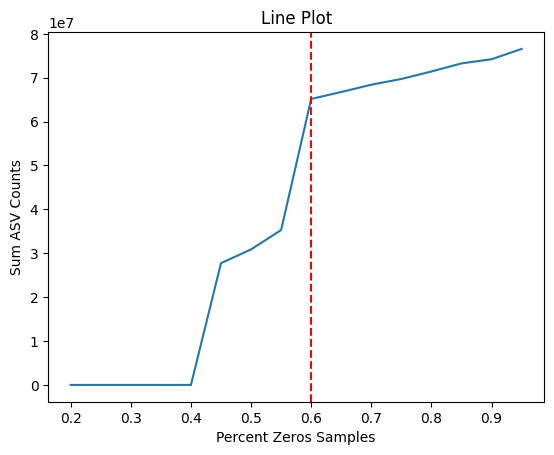

In [22]:
import matplotlib.pyplot as plt

# Extract the x and y values from the DataFrame
x = df['PercentZerosSamples']
y = df['SumASVCounts']

# Create the line plot
plt.plot(x, y)

# First percent zeros value that accounts for more than 50% of the sum of ASV counts
plt.axvline(x=0.6, color='red', linestyle='--')

# Add labels and title
plt.xlabel('Percent Zeros Samples')
plt.ylabel('Sum ASV Counts')
plt.title('Line Plot')

# Display the plot
plt.show()

# Concatenating matrices and computing correlations for the ASVs


In [24]:
wallace_asvs_zeros_filtered_0_6.shape

(25, 482)

In [25]:
print('Total ASV counts:', wallace_asvs_zeros_filtered_0_6.sum().sum())
print(wallace_asvs_zeros_filtered_0_6.shape)

Total ASV counts: 65161824.0
(25, 482)


In [26]:
kremling_expression_v5_zeros_filtered = count_zeros(kremling_expression_v5, 0.5)

Threshold: 241 (threshold * number of columns)


In [27]:
concatenated_df = pd.concat([kremling_expression_v5_zeros_filtered,
                             wallace_asvs_zeros_filtered_0_6], axis=0)

In [29]:
print(wallace_asvs.shape)
print(wallace_asvs_zeros_filtered_0_6.shape)
print(kremling_expression_v5_zeros_filtered.shape)
print(concatenated_df.shape)

(6241, 482)
(25, 482)
(19953, 482)
(19978, 482)


In [30]:
wallace_asvs_zeros_filtered_0_6.index

Index(['bc664ea528899e36452dd37c1f55a48a', '232ad9e267688a5d573112b4855bac96',
       '6967c9a10eff11f751218e759df28ab7', 'fa79d5937f424b58a27843dfff8bdcd4',
       'e6b96dce8fbd261b8836b93b9a1d5e07', '1674323e4fe615dc003edd628305bc9f',
       '6935437446b9c69c21f6ac4518b2eb04', '8db37fcbc11f63d8a46690adeb7cad70',
       '52c0751a4259810b7c12be45c6597335', 'e588c7fc94221bf561c85d536b986ef9',
       'd8fac1aa74436b8041e29a3237da7955', 'd7386797b5be1ee26245561ee11ce7d4',
       'a183e60f5b7089fea745a764cbfef235', '3f23cb45b80bde9e7c74ad4523840175',
       '5cf8ff48a356c41a6ee80503a629821e', '027bb6b1ccc870ba310fa413c75eb901',
       '225bc1cb152b786927ca748b98403d94', '876139714249d7a0203594416545eda6',
       '3604c3db81e843ae99b2817b1777d4f7', '7f54a6ceefa69d7d1934eedbc709902a',
       'a6c946adedd20c184243c5a9580120c7', 'dc8c3ff51b0e92f1f7a0c879437a6185',
       'f57a99c7dcda98829b197f9ab9c0abdb', '41238493ed071930f0729c8a8c1115a8',
       '089df82153e0fc89ce4dd33e2fb967a9'],
      dt

In [31]:
concatenated_transposed = concatenated_df.T

At the time of writing, there are at least two interesting approaches:

 * Deep Graph
 * CorALS

I (RACS) decided to start by using CorALS

In [32]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

/media/renato/SSD1TB/Repositories/maize_microbiome_transcriptomics/.venv/lib/python3.10/site-packages/corals/threads.py:48: UserWarning: This function should be called before `numpy` or similar modules are imported.
  warnings.warn("This function should be called before `numpy` or similar modules are imported.")


In [33]:
cor_values = cor_full(concatenated_transposed)
cor_values.shape

(19978, 19978)

In [34]:
cor_values.head()

Name,Zm00001eb371370_T002,Zm00001eb371280_T001,Zm00001eb371250_T001,Zm00001eb371230_T001,Zm00001eb371180_T001,Zm00001eb371100_T001,Zm00001eb371080_T001,Zm00001eb371040_T001,Zm00001eb371020_T003,Zm00001eb371000_T001,...,027bb6b1ccc870ba310fa413c75eb901,225bc1cb152b786927ca748b98403d94,876139714249d7a0203594416545eda6,3604c3db81e843ae99b2817b1777d4f7,7f54a6ceefa69d7d1934eedbc709902a,a6c946adedd20c184243c5a9580120c7,dc8c3ff51b0e92f1f7a0c879437a6185,f57a99c7dcda98829b197f9ab9c0abdb,41238493ed071930f0729c8a8c1115a8,089df82153e0fc89ce4dd33e2fb967a9
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.000000,0.142889,0.039475,0.022920,-0.105995,-0.039963,-0.276144,-0.048941,0.113669,0.231292,...,-0.060603,-0.039229,-0.078264,-0.038630,-0.040562,-0.035213,-0.103850,-0.037266,-0.032844,-0.063857
Zm00001eb371280_T001,0.142889,1.000000,0.034472,-0.064242,-0.188289,-0.035362,-0.170601,-0.104686,-0.032718,0.101106,...,-0.047553,-0.045043,0.004255,-0.044677,-0.045693,0.014529,-0.020605,0.011820,0.015935,-0.045383
Zm00001eb371250_T001,0.039475,0.034472,1.000000,0.047259,0.129120,0.120366,0.203325,-0.038570,-0.013945,0.063081,...,-0.019800,0.025180,-0.057109,0.025648,0.025160,0.021724,0.013483,0.020676,0.013475,0.014003
Zm00001eb371230_T001,0.022920,-0.064242,0.047259,1.000000,-0.066383,-0.045272,0.032876,-0.006981,-0.026610,0.050676,...,-0.004863,0.105754,0.009740,0.106119,0.105870,0.148336,0.065120,0.149689,0.150416,0.064002
Zm00001eb371180_T001,-0.105995,-0.188289,0.129120,-0.066383,1.000000,0.298561,0.143125,0.114126,0.033844,-0.093998,...,0.082671,0.144744,0.065561,0.144433,0.144924,0.033604,0.081008,0.037630,0.028684,0.067261


In [36]:
highly_correlated_pairs_df = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
correlated_pairs_file = open('correlated_pairs_asvs0_4_pearson_testingsignificance.txt', 'w')

# Find the highly correlated pairs
for i in range(len(cor_values.columns)):
    for j in range(i+1, len(cor_values.columns)):
        if cor_values.columns[i] == cor_values.columns[j] or\
            (cor_values.columns[j].startswith('Zm') and cor_values.columns[i].startswith('Zm')):
            continue
        if ((abs(cor_values.iloc[i, j]) > 0.4) or\
           (abs(cor_values.iloc[i, j]) < -0.4)) and\
            (cor_values.columns[j].startswith('Zm') or cor_values.columns[i].startswith('Zm')):
            pair = (cor_values.columns[i], cor_values.columns[j])
            highly_correlated_pairs_df.loc[len(highly_correlated_pairs_df.index)] = [cor_values.columns[i],
                                                                                     cor_values.columns[j],
                                                                                     cor_values.iloc[i, j]]
            correlated_pairs_file.write(f'{cor_values.columns[i]}\t{cor_values.columns[j]}\t{cor_values.iloc[i, j]}\n')

correlated_pairs_file.close()

In [46]:
import numpy as np
from scipy import stats

rng = np.random.default_rng()
method = stats.PermutationMethod(n_resamples=10000, random_state=rng)
stats.pearsonr(concatenated_transposed['Zm00001eb167720_T001'],
               concatenated_transposed['7f54a6ceefa69d7d1934eedbc709902a'],
               method=method)

PearsonRResult(statistic=0.7175578549815284, pvalue=0.0021997800219978004)

In [47]:
cor_values_spearman = cor_full(concatenated_transposed, correlation_type='spearman')
cor_values_spearman.shape

(19978, 19978)

In [48]:
cor_values_spearman = pd.DataFrame(cor_values_spearman,
                        columns=cor_values.columns,
                        index=cor_values.index)

In [37]:
cor_values_spearman.head()

Name,Zm00001eb371370_T002,Zm00001eb371280_T001,Zm00001eb371250_T001,Zm00001eb371230_T001,Zm00001eb371180_T001,Zm00001eb371100_T001,Zm00001eb371080_T001,Zm00001eb371040_T001,Zm00001eb371030_T001,Zm00001eb371020_T003,...,26f109dfa25a5fb711158e5a93d8cbc9,832082793d1e3b73f25321f3221313ed,8db37fcbc11f63d8a46690adeb7cad70,232ad9e267688a5d573112b4855bac96,9d34bf2c7694126ba091a57741a753a7,81c543b79567e606198ad77b86540a8e,52c0751a4259810b7c12be45c6597335,1674323e4fe615dc003edd628305bc9f,3604c3db81e843ae99b2817b1777d4f7,089df82153e0fc89ce4dd33e2fb967a9
Name,,,,,,,,,,,,,,,,,,,,,
Zm00001eb371370_T002,1.000000,0.173093,0.026813,0.042199,-0.156627,-0.020855,-0.306951,-0.050014,-0.040115,0.121308,...,-0.048886,0.107343,-0.124717,0.097509,-0.010226,-0.140585,-0.066453,-0.059133,-0.159401,-0.102316
Zm00001eb371280_T001,0.173093,1.000000,0.105804,0.002878,-0.170803,-0.039391,-0.173197,-0.025750,-0.039548,0.010718,...,0.091379,0.085491,0.070528,0.131783,-0.058099,-0.042829,0.075519,0.083015,-0.050521,0.059037
Zm00001eb371250_T001,0.026813,0.105804,1.000000,0.054483,0.109083,0.087022,0.172831,-0.015536,0.079298,-0.008292,...,0.013869,-0.018872,0.095085,-0.019586,0.025660,0.083180,0.045849,0.042646,0.064421,0.077339
Zm00001eb371230_T001,0.042199,0.002878,0.054483,1.000000,-0.136429,-0.097964,0.145410,0.040400,-0.022196,-0.025770,...,-0.023695,-0.121275,0.013833,-0.060938,0.050251,0.074419,-0.040958,-0.040183,0.071446,0.020355
Zm00001eb371180_T001,-0.156627,-0.170803,0.109083,-0.136429,1.000000,0.295248,0.063001,0.110594,0.244337,-0.009532,...,0.008467,0.025179,0.035690,-0.011652,0.071673,0.037734,0.012133,0.008606,0.088670,0.085994


In [38]:
highly_correlated_pairs_df = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
correlated_pairs_file = open('correlated_pairs_asvs0_4_spearman_testingsignificance', 'w')

# Find the highly correlated pairs
for i in range(len(cor_values_spearman.columns)):
    for j in range(i+1, len(cor_values_spearman.columns)):
        if cor_values_spearman.columns[i] == cor_values_spearman.columns[j] or\
            (cor_values_spearman.columns[j].startswith('Zm') and cor_values_spearman.columns[i].startswith('Zm')):
            continue
        if ((abs(cor_values_spearman.iloc[i, j]) > 0.4) or\
           (abs(cor_values_spearman.iloc[i, j]) < -0.4)) and\
            (cor_values_spearman.columns[j].startswith('Zm') or cor_values_spearman.columns[i].startswith('Zm')):
            pair = (cor_values_spearman.columns[i], cor_values_spearman.columns[j])
            highly_correlated_pairs_df.loc[len(highly_correlated_pairs_df.index)] = [cor_values_spearman.columns[i],
                                                                                     cor_values_spearman.columns[j],
                                                                                     cor_values_spearman.iloc[i, j]]
            correlated_pairs_file.write(f'{cor_values_spearman.columns[i]}\t{cor_values_spearman.columns[j]}\t{cor_values_spearman.iloc[i, j]}\n')

correlated_pairs_file.close()

# Calculating p-values and corrected p-values

In [ ]:
from corals.correlation.topk.default import cor_topk
cor_topk_values, cor_topk_coo = cor_topk(concatenated_transposed, correlation_type="spearman", k=0.001, n_jobs=8)

from corals.correlation.utils import derive_pvalues, multiple_test_correction
n_samples = concatenated_transposed.shape[0]
n_features = concatenated_transposed.shape[1]

# calculate p-values
pvalues = derive_pvalues(cor_topk_values, n_samples)

# multiple hypothesis correction
pvalues_corrected = multiple_test_correction(pvalues, n_features, method="fdr_bh")

In [ ]:
pvalues_corrected

In [ ]:
pvalues

In [ ]:
concatenated_transposed.head()

In [ ]:
from corals.correlation.topk.default import cor_topk
cor_topk_values_pearson, cor_topk_coo_pearson = cor_topk(concatenated_transposed, correlation_type="pearson", k=0.001, n_jobs=8)

from corals.correlation.utils import derive_pvalues, multiple_test_correction
n_samples = concatenated_transposed.shape[0]
n_features = concatenated_transposed.shape[1]

# calculate p-values
pvalues_pearson = derive_pvalues(cor_topk_values_pearson, n_samples)

# multiple hypothesis correction
pvalues_corrected_pearson = multiple_test_correction(pvalues, n_features, method="fdr_bh")

In [ ]:
concatenated_transposed.head()

# Computing correlations between RNAseq and Metataxonomic data after colapsing to phylotypes

Given the sparsity of running correlation analyses between gene expression and ASVs, an alternative (and possibly better) solution is to colapse ASVs generated with Dada2 into phylotypes. A promising way to do it is using methods implemented by [Minot et al (2023)](https://doi.org/10.1016/j.crmeth.2023.100639), who described the Nextflow workflow MaLiAmPi and the Python package called "phylotypes".

I (RACS) installed phylotypes and dependencies in a conda environment with Python 3.10 (which can be used to install all of its dependencies).

Two files will be used to generate the matrix with counts by sample and phylotypes:

 * `dada2.sv.shared.txt`, which contains the SV counts in a TSV format similar to mothur sharefile. (described [here](https://github.com/jgolob/maliampi))
 * `phylotypes_maliampi_q20_fw`, output of phylotypes, which is described [here](https://github.com/jgolob/phylotypes)

In [ ]:
dada2_sv_shared_df = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/maliampi_phylotypes/dada2.sv.shared.txt', sep='\t')
dada2_sv_shared_df = dada2_sv_shared_df.rename(columns={'label': 'sv'}) # Rename the column to sv
dada2_sv_shared_df.drop(columns=['group', 'numsvs'], inplace=True) # Drop the columns group and numsvs
dada2_sv_shared_df.set_index('sv', inplace=True) # Set the index to sv
dada2_sv_shared_transposed_df = dada2_sv_shared_df.transpose() # Transpose the dataframe
dada2_sv_shared_transposed_df = dada2_sv_shared_transposed_df.rename_axis('sv') # Rename the index to sv
dada2_sv_shared_transposed_df.head()

In [ ]:
phylotypes_maliampi_q20_fw_df = pd.read_csv('/home/rsantos/Repositories/maize_microbiome_transcriptomics/16S_wallace2018/maliampi_phylotypes/phylotypes_maliampi_q20_fw_1_0.txt')
phylotypes_maliampi_q20_fw_df[['sv_from_str',
                               'sample']] = phylotypes_maliampi_q20_fw_df['sv'].str.split(":",
                                                                                          regex=True,
                                                                                          expand=True) # Split the sv column into two columns
phylotypes_maliampi_q20_fw_df.drop(columns=['sv', 'sample'], inplace=True) # Drop the sv and sample columns
phylotypes_maliampi_q20_fw_df = phylotypes_maliampi_q20_fw_df.rename(columns={'sv_from_str': 'sv'}) # Rename the column to sv
phylotypes_maliampi_q20_fw_df.head()

In [ ]:
phylotypes_counts_df = pd.merge(phylotypes_maliampi_q20_fw_df,
         dada2_sv_shared_transposed_df,
         on='sv',
         how='inner') # Merge the two dataframes on the sv column
phylotypes_counts_df.drop(columns=['sv'], inplace=True) # Drop the sv column
phylotypes_counts_df.set_index('phylotype', inplace=True) # Set the index to phylotype
phylotypes_counts_df.head()

In [ ]:
sum_by_group = phylotypes_counts_df.groupby('phylotype').sum()
sum_by_group.head()

In [ ]:
count_zeros(sum_by_group, threshold=0.5)

In [ ]:
wallace_phylotypes_zeros_filtered = count_zeros(sum_by_group)
wallace_phylotypes_zeros_filtered.shape

In [ ]:
wallace_phylotypes_zeros_filtered = wallace_phylotypes_zeros_filtered.rename(columns=run2my_sample_id)
wallace_phylotypes_zeros_filtered.columns = [str(x) for x in wallace_phylotypes_zeros_filtered.columns]
wallace_phylotypes_zeros_filtered.head()

In [ ]:
# Filter the columns of the expression data
wallace_phylotypes_zeros_filtered = wallace_phylotypes_zeros_filtered.filter(items=kremling_expression_v5.columns)
wallace_phylotypes_zeros_filtered.head()

In [ ]:
concatenated_phylotypes_df = pd.concat([wallace_phylotypes_zeros_filtered, kremling_expression_v5_zeros_filtered], axis=0)
print(kremling_expression_v5_zeros_filtered.shape)
print(wallace_phylotypes_zeros_filtered.shape)
print(concatenated_phylotypes_df.shape)

In [ ]:
concatenated_phylotypes_transposed = concatenated_phylotypes_df.T

In [ ]:
from corals.threads import set_threads_for_external_libraries
set_threads_for_external_libraries(n_threads=1)
import numpy as np
from corals.correlation.full.default import cor_full

phylotypes_cor_values = cor_full(concatenated_phylotypes_transposed)
print(f'Finished all correlations with {phylotypes_cor_values.shape[0]} vs {phylotypes_cor_values.shape[1]}!')

highly_correlated_pairs_phylotypes_df = pd.DataFrame(columns=['feature1', 'feature2', 'correlation'])
correlated_pairs_phylotypes_file = open('correlated_pairs_phylotypes_v2.txt', 'w')

# Find the highly correlated pairs
for i in range(len(phylotypes_cor_values.columns)):
    for j in range(i+1, len(phylotypes_cor_values.columns)):
        if phylotypes_cor_values.columns[i] == phylotypes_cor_values.columns[j] or\
            (phylotypes_cor_values.columns[j].startswith('Zm') and phylotypes_cor_values.columns[i].startswith('Zm')) or\
            (not phylotypes_cor_values.columns[j].startswith('Zm') and not phylotypes_cor_values.columns[i].startswith('Zm')):
            continue
        if (abs(phylotypes_cor_values.iloc[i, j]) > 0.6 or\
           abs(phylotypes_cor_values.iloc[i, j]) < -0.6) and\
            (phylotypes_cor_values.columns[j].startswith('Zm') or phylotypes_cor_values.columns[i].startswith('Zm')):
            pair = (phylotypes_cor_values.columns[i], phylotypes_cor_values.columns[j])
            highly_correlated_pairs_phylotypes_df.loc[len(highly_correlated_pairs_phylotypes_df.index)] = [phylotypes_cor_values.columns[i],
                                                                                     phylotypes_cor_values.columns[j],
                                                                                     phylotypes_cor_values.iloc[i, j]]
            correlated_pairs_phylotypes_file.write(f'{phylotypes_cor_values.columns[i]}\t{phylotypes_cor_values.columns[j]}\t{phylotypes_cor_values.iloc[i, j]}\n')

correlated_pairs_phylotypes_file.close()